In [ ]:
!git clone https://github.com/aubinbnf/Speech-Emotion-Recognition.git
%cd Speech-Emotion-Recognition
# !git branch -r
# !git switch TESS
# !git switch simon
# !git status
# !git pull TESS



Cloning into 'Speech-Emotion-Recognition'...
remote: Enumerating objects: 14429, done.
remote: Counting objects: 100% (1591/1591), done.
remote: Compressing objects: 100% (1532/1532), done.
remote: Total 14429 (delta 61), reused 1580 (delta 51), pack-reused 12838 (from 1)
Receiving objects: 100% (14429/14429), 775.69 MiB | 19.05 MiB/s, done.
Resolving deltas: 100% (321/321), done.
Updating files: 100% (8432/8432), done.
/content/Speech-Emotion-Recognition


In [ ]:
%ls
%cd Speech-Emotion-Recognition



 audio_representations/   CNNBLSTM_ATTENTION/   LSTM/                 VGG/
 CNN/                    'data management'/     PARALELLECNN/
 CNNBLSTM/                EXTRAS_MODELS/       'Results and plots'/
[Errno 2] No such file or directory: 'Speech-Emotion-Recognition'
/content/Speech-Emotion-Recognition


Using GPU: /physical_device:GPU:0
Training set: (1628, 224, 224, 3), (1628, 8)
Validation set: (349, 224, 224, 3), (349, 8)
Test set: (350, 224, 224, 3), (350, 8)

Training VGG19 model...
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 56s 393ms/step - accuracy: 0.2098 - loss: 1.9557 - val_accuracy: 0.5501 - val_loss: 1.1741
Epoch 2/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - accuracy: 0.5462 - loss: 1.2157 - val_accuracy: 0.6991 - val_loss: 0.8562
Epoch 3/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 20s 180ms/step - accuracy: 0.6574 - loss: 0.9332 - val_accuracy: 0.6934 - val_loss: 0.7961
Epoch 4/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 22s 192ms/step - accuracy: 0.7543 - loss: 0.6744 - val_accuracy: 0.7049 - val_loss: 0.8192
Epoch 5/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 28s 262ms/step - accuracy: 0.7518 - loss: 0.6731 - val_accuracy: 0.7278 - val_loss: 0.7154
Epoch 6/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 39s 244ms/step - accuracy: 0.7926 - loss: 0.5766 - val_accuracy: 0

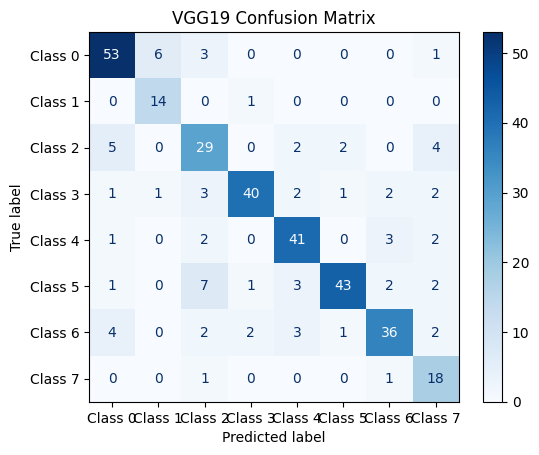


Training ResNet50 model...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 110s 632ms/step - accuracy: 0.3510 - loss: 1.7269 - val_accuracy: 0.1404 - val_loss: 2.0828
Epoch 2/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 94s 387ms/step - accuracy: 0.6721 - loss: 0.8581 - val_accuracy: 0.3209 - val_loss: 1.9798
Epoch 3/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 45s 441ms/step - accuracy: 0.7883 - loss: 0.6039 - val_accuracy: 0.4670 - val_loss: 1.5859
Epoch 4/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 92s 544ms/step - accuracy: 0.8511 - loss: 0.4256 - val_accuracy: 0.5616 - val_loss: 1.4193
Epoch 5/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 96s 684ms/step - accuracy: 0.9032 - loss: 0.3206 - val_accuracy: 0.7307 - val_loss: 0.9211
Epoch 6/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 25s 121ms/step - accuracy: 0.9298 - loss: 0.2502 - val_accuracy: 0.7307 - val_loss: 0.8660
Epoch 7/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 103s 934ms/step - accuracy: 0.9601 - loss: 0.1290 - val_accuracy: 0.7851 - val_loss: 0.9068
Ep

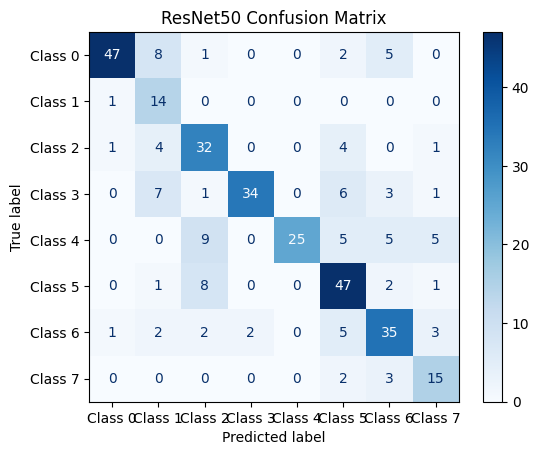

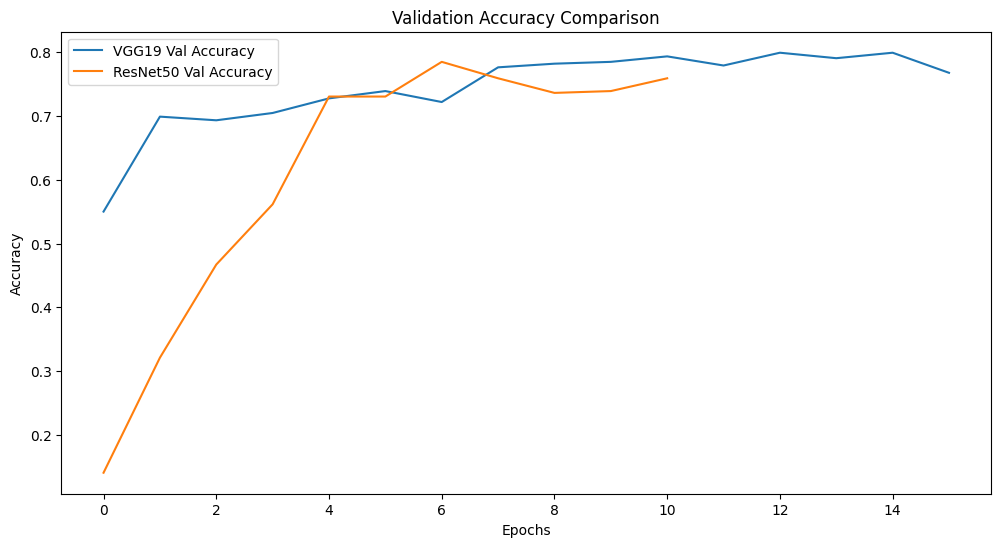

In [ ]:
#!/usr/bin/env python3

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import VGG19, ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from PIL import Image

# ==========================
# GPU CONFIGURATION
# ==========================
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Using GPU:", physical_devices[0].name)
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU found. Using CPU.")

# ==========================
# DATA LOADING AND PREPROCESSING
# ==========================
dataset_dirs = {
    "audio_representations/audio_representations_savee/spectrograms/": 1,
    "audio_representations/audio_representations_Tess/spectrograms/": 0.4,
    "audio_representations/audio_representations_ravdess/spectrograms/": 0.7
}

images, labels = [], []

for dataset_dir, sampling_rate in dataset_dirs.items():
    all_files = [f for f in os.listdir(dataset_dir) if f.endswith(".png")]
    sampled_files = np.random.choice(all_files, size=int(len(all_files) * sampling_rate), replace=False)

    for file_name in sampled_files:
        file_path = os.path.join(dataset_dir, file_name)
        img = Image.open(file_path).convert("RGB").resize((224, 224))
        images.append(np.array(img))

        parts = file_name.split("-")
        if len(parts) >= 3:
            label_raw = int(parts[2]) - 1
        else:
            print(f"Skipping {file_name}: Incorrect format.")
            continue
        labels.append(label_raw)

images = np.array(images) / 255.0
labels = np.array(labels)
num_classes = len(np.unique(labels))

labels_one_hot = to_categorical(labels, num_classes=num_classes)

X_train, X_temp, y_train, y_temp = train_test_split(images, labels_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# ==========================
# DATA AUGMENTATION
# ==========================
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True
)

# Visualize some augmented images
for x_batch, y_batch in data_augmentation.flow(X_train, y_train, batch_size=9):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x_batch[i])
        plt.axis('off')
    plt.show()
    break

# ==========================
# MODEL FUNCTIONS
# ==========================
def create_vgg19_model():
    base_model = VGG19(weights='imagenet', pooling='avg', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers[:12]:
        layer.trainable = False
    model = Sequential([
        base_model,
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

def create_resnet50_model():
    base_model = ResNet50(weights='imagenet', pooling='avg', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers[:50]:
        layer.trainable = False
    model = Sequential([
        base_model,
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

# ==========================
# EXPERIMENTAL SETUP
# ==========================
models_to_test = {
    "VGG19": create_vgg19_model,
    "ResNet50": create_resnet50_model
}

results = {}
for model_name, model_func in models_to_test.items():
    print(f"\nTraining {model_name} model...")
    model = model_func()
    model.compile(optimizer=optimizers.Adam(5e-5),
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])

    callbacks = [
        ModelCheckpoint(f"{model_name}_best_model.keras", monitor="val_accuracy", save_best_only=True, mode="max"),
        ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.95, min_lr=0.000001),
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]

    history = model.fit(
        data_augmentation.flow(X_train, y_train, batch_size=16),
        epochs=40,
        shuffle=True,
        validation_data=(X_val, y_val),
        callbacks=callbacks
    )

    test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    print("Classification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=[f"Class {i}" for i in range(num_classes)]))

    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[f"Class {i}" for i in range(num_classes)])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    results[model_name] = {
        "history": history.history,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy
    }

# ==========================
# COMPARATIVE PLOTS
# ==========================
plt.figure(figsize=(12, 6))

for model_name, data in results.items():
    plt.plot(data['history']['val_accuracy'], label=f'{model_name} Val Accuracy')

plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


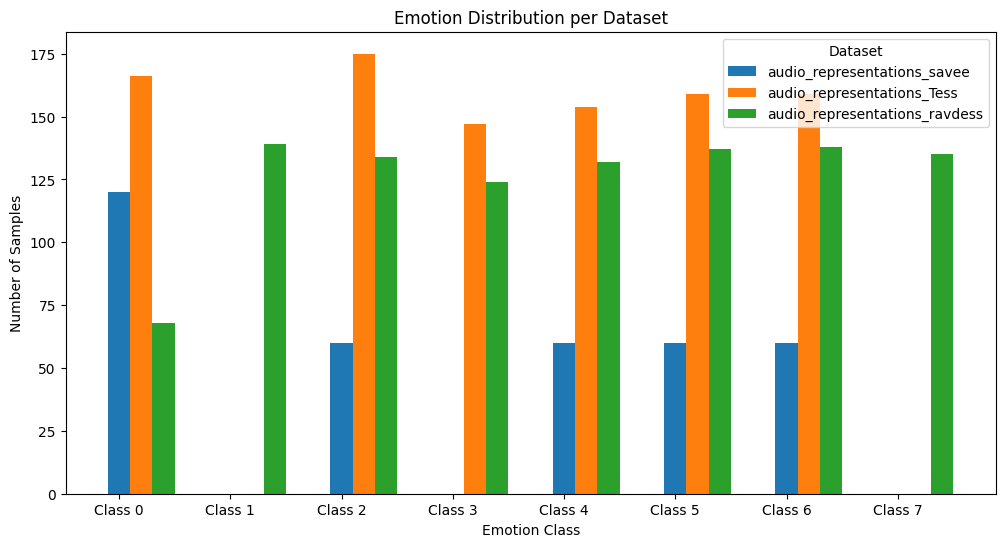

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# ==========================
# DATA DISTRIBUTION PER DATASET AND CLASS
# ==========================
emotion_counts = {dataset: Counter() for dataset in dataset_dirs}

# Iterate through the dataset directories and count the emotions
for dataset_dir, sampling_rate in dataset_dirs.items():
    all_files = [f for f in os.listdir(dataset_dir) if f.endswith(".png")]
    sampled_files = np.random.choice(all_files, size=int(len(all_files) * sampling_rate), replace=False)

    for file_name in sampled_files:
        parts = file_name.split("-")
        if len(parts) >= 3:
            label_raw = int(parts[2]) - 1  # Emotion label
            emotion_counts[dataset_dir][label_raw] += 1

# Plotting the distribution of emotions per dataset
plt.figure(figsize=(12, 6))
for i, (dataset, counts) in enumerate(emotion_counts.items()):
    labels = list(counts.keys())
    values = list(counts.values())
    plt.bar(np.array(labels) + i * 0.2, values, width=0.2, label=dataset.split("/")[1])  # Slight offset for each dataset

plt.title('Emotion Distribution per Dataset')
plt.xlabel('Emotion Class')
plt.ylabel('Number of Samples')
plt.xticks(np.arange(num_classes), [f"Class {i}" for i in range(num_classes)])
plt.legend(title='Dataset')
plt.show()


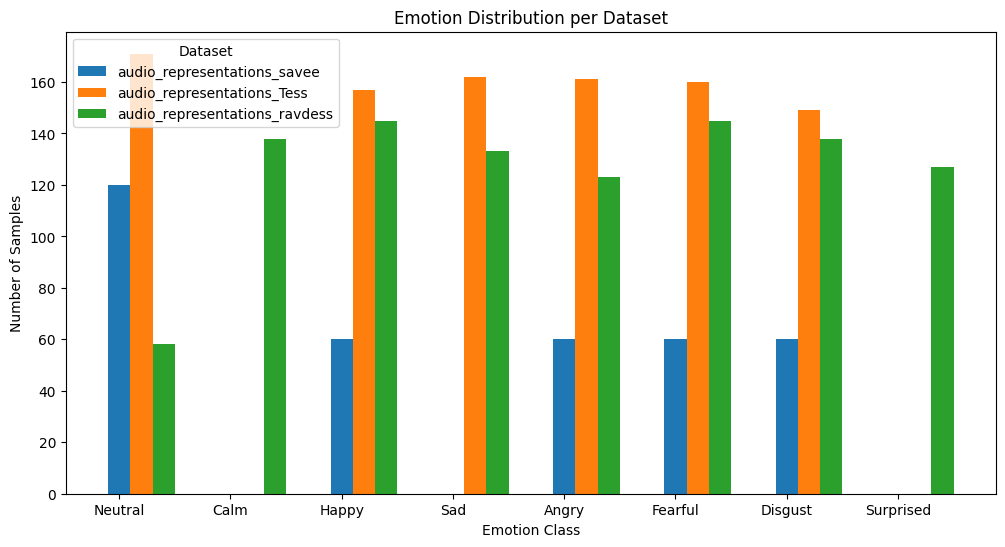

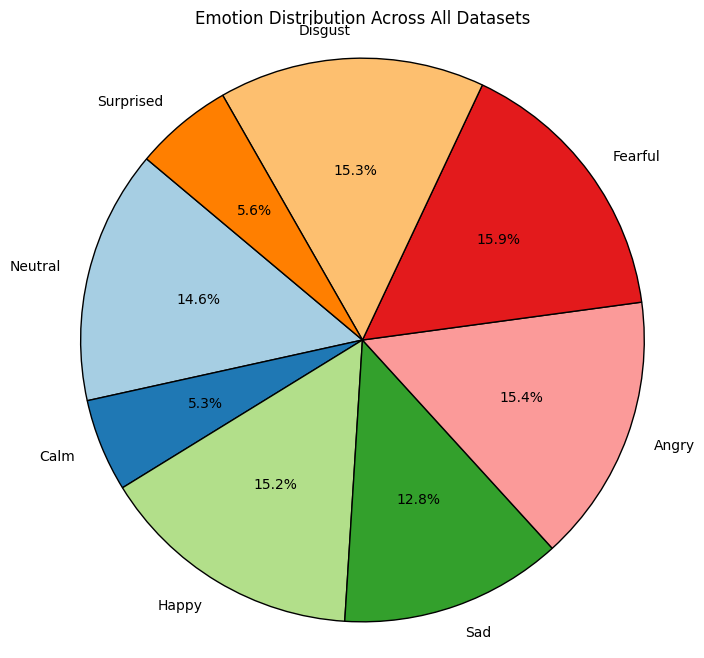

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Emotion label mapping based on the provided codes
emotion_labels = {
    0: "Neutral",
    1: "Calm",
    2: "Happy",
    3: "Sad",
    4: "Angry",
    5: "Fearful",
    6: "Disgust",
    7: "Surprised"
}

# ==========================
# DATA DISTRIBUTION PER DATASET AND CLASS
# ==========================
emotion_counts = {dataset: Counter() for dataset in dataset_dirs}

# Iterate through the dataset directories and count the emotions
for dataset_dir, sampling_rate in dataset_dirs.items():
    all_files = [f for f in os.listdir(dataset_dir) if f.endswith(".png")]
    sampled_files = np.random.choice(all_files, size=int(len(all_files) * sampling_rate), replace=False)

    for file_name in sampled_files:
        parts = file_name.split("-")
        if len(parts) >= 3:
            label_raw = int(parts[2]) - 1  # Emotion label
            emotion_counts[dataset_dir][label_raw] += 1

# ==========================
# Bar chart for emotion distribution per dataset
# ==========================
plt.figure(figsize=(12, 6))
for i, (dataset, counts) in enumerate(emotion_counts.items()):
    labels = list(counts.keys())
    values = list(counts.values())
    plt.bar(np.array(labels) + i * 0.2, values, width=0.2, label=dataset.split("/")[1])  # Slight offset for each dataset

plt.title('Emotion Distribution per Dataset')
plt.xlabel('Emotion Class')
plt.ylabel('Number of Samples')
plt.xticks(np.arange(len(emotion_labels)), list(emotion_labels.values()))
plt.legend(title='Dataset')
plt.show()

# ==========================
# Pie chart for total emotion distribution across all datasets
# ==========================
total_emotion_counts = Counter()

# Iterate through the dataset directories and count the emotions
for dataset_dir, sampling_rate in dataset_dirs.items():
    all_files = [f for f in os.listdir(dataset_dir) if f.endswith(".png")]
    sampled_files = np.random.choice(all_files, size=int(len(all_files) * sampling_rate), replace=False)

    for file_name in sampled_files:
        parts = file_name.split("-")
        if len(parts) >= 3:
            label_raw = int(parts[2]) - 1  # Emotion label
            total_emotion_counts[label_raw] += 1

# Prepare data for the pie chart
sizes = [total_emotion_counts[i] for i in range(len(emotion_labels))]
colors = plt.cm.Paired(range(len(emotion_labels)))  # Color palette for the classes

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=list(emotion_labels.values()), autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops={'edgecolor': 'black'})
plt.title('Emotion Distribution Across All Datasets')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


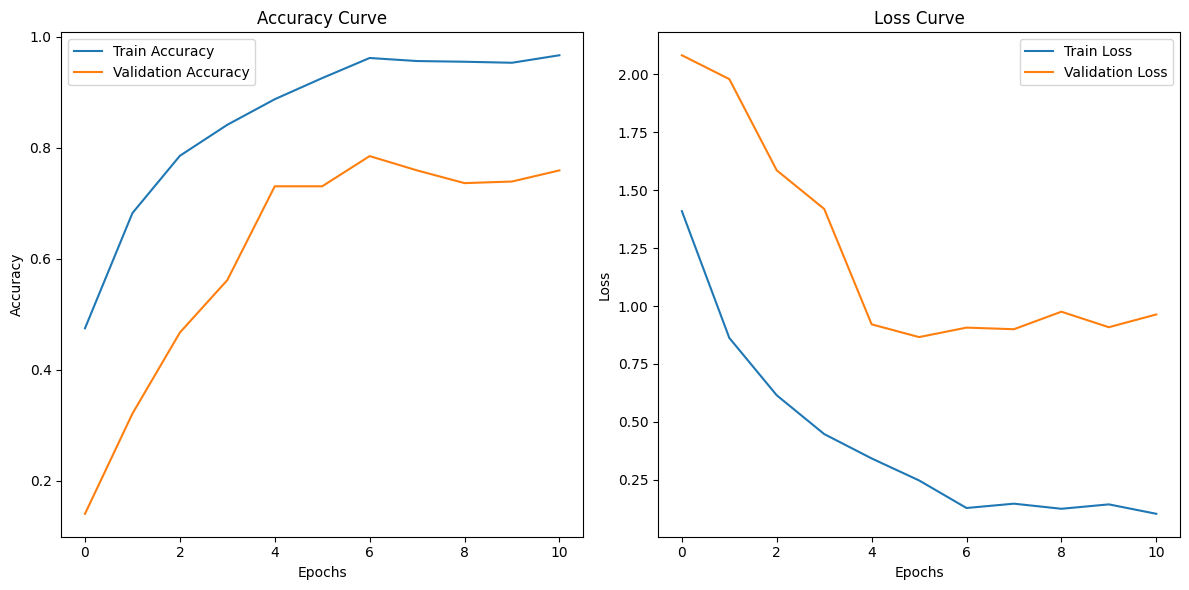

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
Classification Report:
              precision    recall  f1-score   support

     neutral       0.94      0.75      0.83        63
        calm       0.39      0.93      0.55        15
       happy       0.60      0.76      0.67        42
         sad       0.94      0.65      0.77        52
       angry       1.00      0.51      0.68        49
     fearful       0.66      0.80      0.72        59
     disgust       0.66      0.70      0.68        50
   surprised       0.58      0.75      0.65        20

    accuracy                           0.71       350
   macro avg       0.72      0.73      0.69       350
weighted avg       0.78      0.71      0.72       350



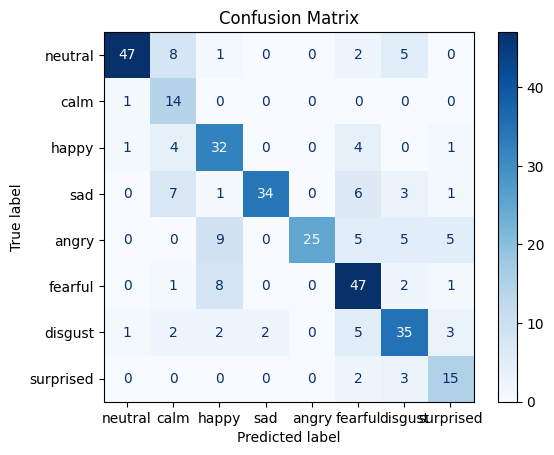

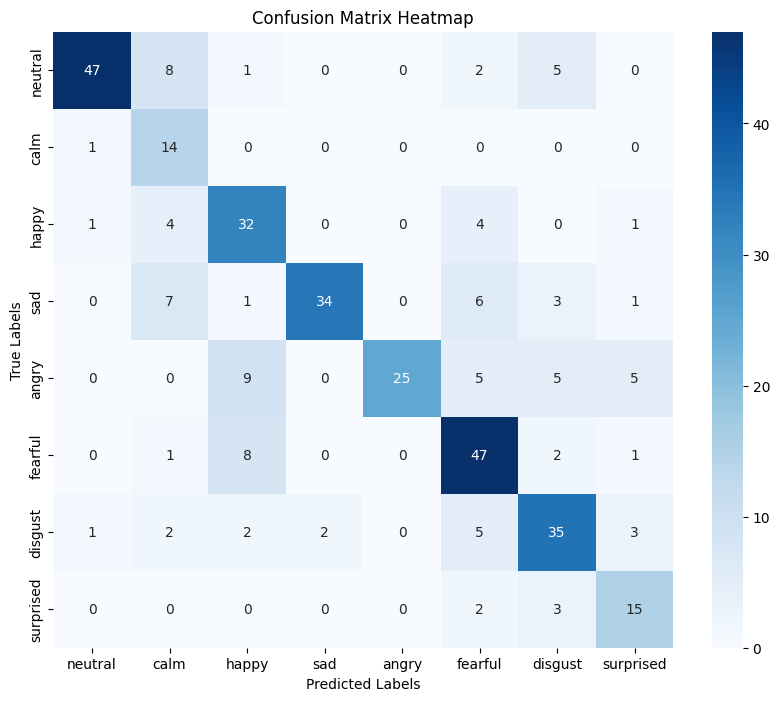

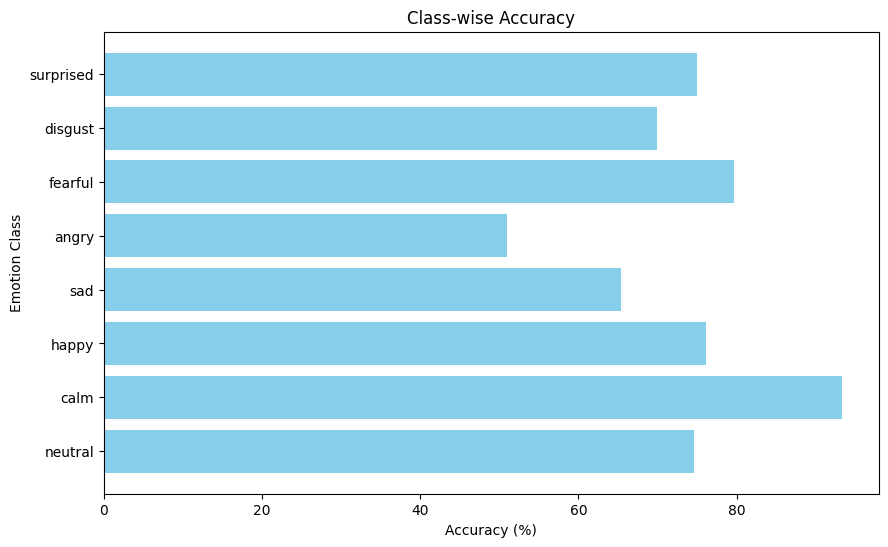

In [ ]:
# ==========================
# ADDITIONAL VISUALIZATIONS AND PLOTS
# ==========================
import seaborn as sns

# Emotion labels
emotion_labels = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised",
    "09": "other",  # If there are additional labels
    # Add any other labels as needed...
}
# Plot training history
plt.figure(figsize=(12, 6))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# ==========================
# CONFUSION MATRIX AND CLASSIFICATION REPORT
# ==========================
# Generate predictions for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot to class indices
y_true_classes = np.argmax(y_test, axis=1)

# Compute classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=[emotion_labels[str(i+1).zfill(2)] for i in range(num_classes)]))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[emotion_labels[str(i+1).zfill(2)] for i in range(num_classes)])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ==========================
# ADDITIONAL METRICS PLOTS
# ==========================
# Create a heatmap of the confusion matrix for a more visually appealing plot
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[emotion_labels[str(i+1).zfill(2)] for i in range(num_classes)], yticklabels=[emotion_labels[str(i+1).zfill(2)] for i in range(num_classes)])
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# ==========================
# CLASSWISE ACCURACY PLOT
# ==========================
# Plot class-wise accuracy
class_accuracy = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1) * 100
plt.figure(figsize=(10, 6))
plt.barh([emotion_labels[str(i+1).zfill(2)] for i in range(num_classes)], class_accuracy, color='skyblue')
plt.title("Class-wise Accuracy")
plt.xlabel("Accuracy (%)")
plt.ylabel("Emotion Class")
plt.show()

# ==========================
# NOTES
# ==========================
# 1. The confusion matrix is plotted for a clear visual understanding of true vs predicted labels.
# 2. Classification report is printed to evaluate precision, recall, and F1-score for each emotion class.
# 3. A heatmap of the confusion matrix provides an intuitive understanding of the performance.
# 4. Class-wise accuracy shows how well each emotion class is predicted.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


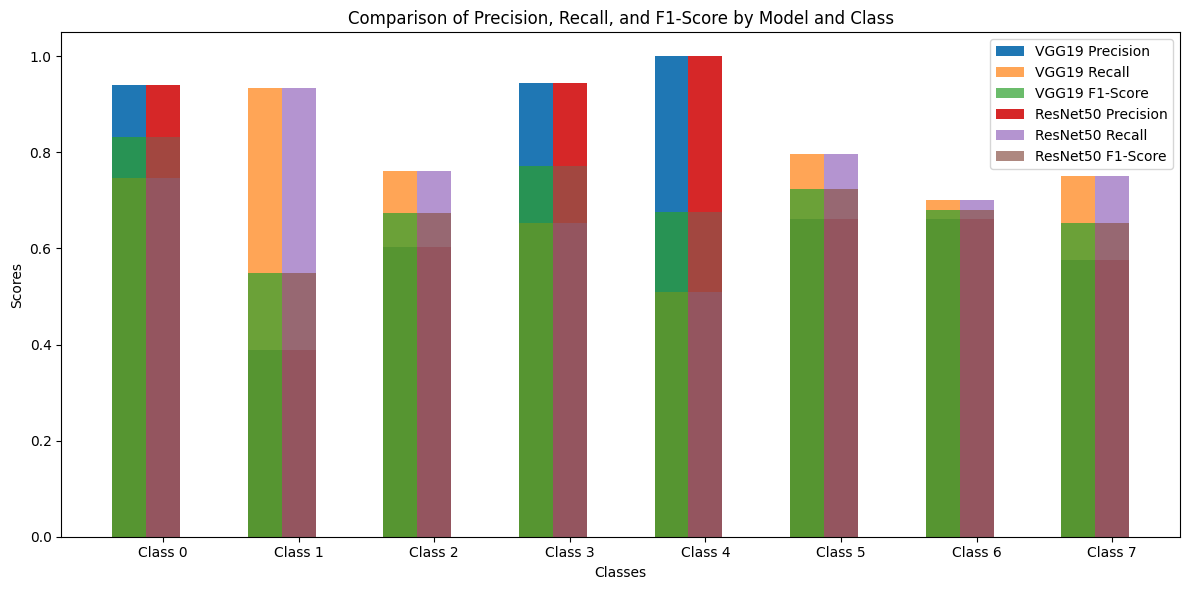

In [ ]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

# Initialisation des dictionnaires pour stocker les métriques
precision_scores = {}
recall_scores = {}
f1_scores = {}

# Parcours des résultats pour calculer les métriques par modèle
for model_name, data in results.items():
    # Extraire les prédictions et les vraies classes
    y_pred = model.predict(X_test)  # Prédictions pour le test set
    y_pred_classes = np.argmax(y_pred, axis=1)  # Classes prédites
    y_true_classes = np.argmax(y_test, axis=1)  # Vraies classes

    # Calculer les métriques pour chaque classe
    report = classification_report(y_true_classes, y_pred_classes, output_dict=True)

    # Extraire les scores de précision, rappel et F1 pour chaque classe
    precision_scores[model_name] = [report[str(i)]['precision'] for i in range(num_classes)]
    recall_scores[model_name] = [report[str(i)]['recall'] for i in range(num_classes)]
    f1_scores[model_name] = [report[str(i)]['f1-score'] for i in range(num_classes)]

# Tracer les métriques pour chaque classe et chaque modèle

x = np.arange(num_classes)  # Positions des classes sur l'axe des x
width = 0.25  # Largeur des barres pour chaque modèle

fig, ax = plt.subplots(figsize=(12, 6))

# Tracer les barres pour chaque modèle et chaque métrique
for i, model_name in enumerate(results.keys()):
    ax.bar(x - width + i * width, precision_scores[model_name], width, label=f'{model_name} Precision')
    ax.bar(x - width + i * width, recall_scores[model_name], width, label=f'{model_name} Recall', alpha=0.7)
    ax.bar(x - width + i * width, f1_scores[model_name], width, label=f'{model_name} F1-Score', alpha=0.7)

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Precision, Recall, and F1-Score by Model and Class')
ax.set_xticks(x)
ax.set_xticklabels([f'Class {i}' for i in range(num_classes)])
ax.legend()

plt.tight_layout()
plt.show()


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


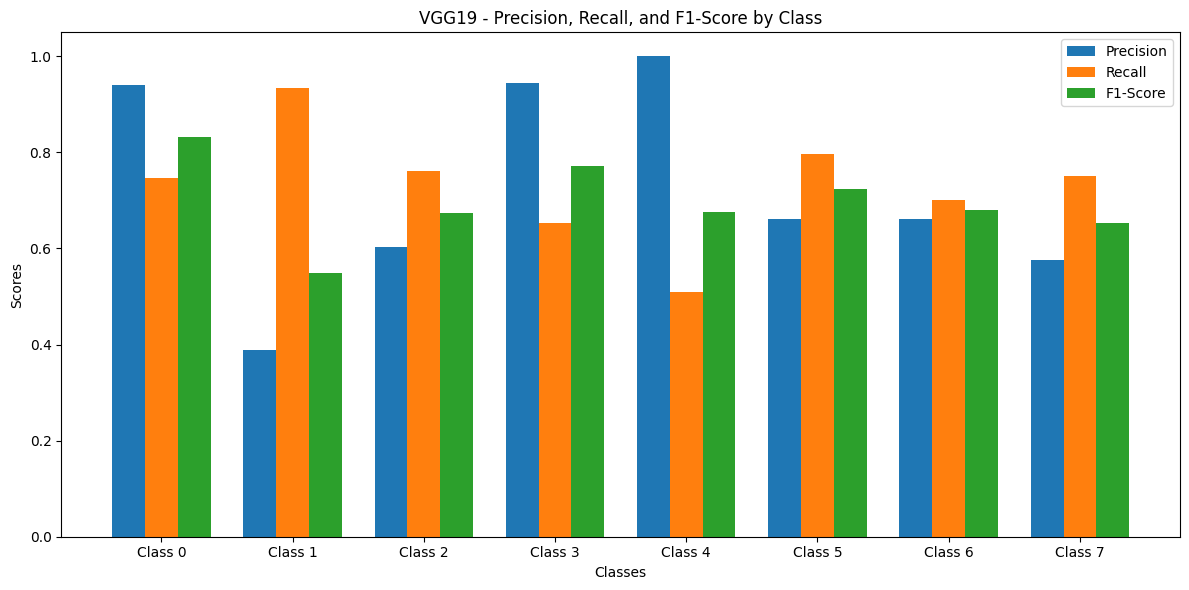

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Spécifiez le nom du modèle que vous voulez afficher (par exemple, "VGG19" ou "ResNet50")
model_name = "VGG19"  # Changez ici pour le modèle que vous souhaitez analyser

# Extraire les prédictions et les vraies classes
y_pred = model.predict(X_test)  # Prédictions pour le test set
y_pred_classes = np.argmax(y_pred, axis=1)  # Classes prédites
y_true_classes = np.argmax(y_test, axis=1)  # Vraies classes

# Calculer les métriques pour chaque classe
report = classification_report(y_true_classes, y_pred_classes, output_dict=True)

# Extraire les scores de précision, rappel et F1 pour chaque classe
precision_scores = [report[str(i)]['precision'] for i in range(num_classes)]
recall_scores = [report[str(i)]['recall'] for i in range(num_classes)]
f1_scores = [report[str(i)]['f1-score'] for i in range(num_classes)]

# Positions des classes sur l'axe des x
x = np.arange(num_classes)
width = 0.25  # Largeur des barres

# Graphique pour la précision, rappel et F1-score sur le même graphique
fig, ax = plt.subplots(figsize=(12, 6))

# Tracer la précision, rappel et F1-score
ax.bar(x - width, precision_scores, width, label='Precision')
ax.bar(x, recall_scores, width, label='Recall')
ax.bar(x + width, f1_scores, width, label='F1-Score')

# Personnaliser l'affichage
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title(f'{model_name} - Precision, Recall, and F1-Score by Class')
ax.set_xticks(x)
ax.set_xticklabels([f'Class {i}' for i in range(num_classes)])
ax.legend()

# Afficher le graphique
plt.tight_layout()
plt.show()
